<a href="https://colab.research.google.com/github/sudhirtakke/Object_Detection_using_YOLOv3/blob/main/Object_Detection_using_YOLOv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Dectection using YOLOv3

- The “**You Only Look Once**,” or YOLO, family of models are a series of end-to-end deep learning models designed for fast object detection.

- The approach involves a single deep convolutional neural network (originally a version of GoogLeNet, later updated and called **DarkNet** based on **VGG**) that splits the input into a grid of cells and each cell directly predicts a bounding box and object classification.

- The result is a large number of candidate bounding boxes that are consolidated into a final prediction by a post-processing step.

- There are three main variations of the approach, **YOLOv1**, **YOLOv2**, and **YOLOv3**.

- We will use **experiencor**’s [keras-yolo3](https://github.com/experiencor/keras-yolo3) project as the basis for performing object detection with a YOLOv3 model.

## Download the Pre-trained Model Weights

- We will download the pre-trained model weights using `wget`.

- These were trained using the DarkNet code base on the **MSCOCO** dataset.


In [1]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2021-05-17 17:26:13--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  23.1MB/s    in 11s     

2021-05-17 17:26:25 (21.4 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



- After this the weights are saved in the current working directory under the name **yolov3.weights**

- We will also **download** a **python script** containing code which will help us **load** the above downloaded **weights** into our model.

- To **simplify** the download, we have created a **zip** file containing the python script.

In [2]:
!wget https://github.com/insaid2018/DeepLearning/raw/master/Data/weight_reader.zip

--2021-05-17 17:26:32--  https://github.com/insaid2018/DeepLearning/raw/master/Data/weight_reader.zip
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/insaid2018/DeepLearning/master/Data/weight_reader.zip [following]
--2021-05-17 17:26:32--  https://raw.githubusercontent.com/insaid2018/DeepLearning/master/Data/weight_reader.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 879 [application/zip]
Saving to: ‘weight_reader.zip’

weight_reader.zip   100%[===================>]     879  --.-KB/s    in 0s      

2021-05-17 17:26:33 (22.2 MB/s) - ‘weight_reader.zip’ saved [879/879]



In [3]:
!unzip -qq weight_reader.zip

In [4]:
!ls

sample_data  weight_reader.py  weight_reader.zip  yolov3.weights


- After **unzipping** the `weight_reader.zip` file, we obtain the `weight_reader.py` file.

- This file contains the **weight reading** code.

## Creating and Saving Model

In [5]:
# Import tensorflow 2.x
# This code block will only work in Google Colab.
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from tensorflow.keras.layers import add, concatenate

- We will import the **WeightReader** class from `weight_reader.py` script.

In [7]:
from weight_reader import WeightReader

### Utility Functions

- We will create functions `_conv_block` and `make_yolov3_model`, which will help us in building our **YOLOv3** model.

In [8]:
# Function to help create custom convolution blocks
def _conv_block(inp, convs, skip=True):
	x = inp
	count = 0
	for conv in convs:
		if count == (len(convs) - 2) and skip:
			skip_connection = x
		count += 1
		if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
		x = Conv2D(conv['filter'],
				   conv['kernel'],
				   strides=conv['stride'],
				   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
				   name='conv_' + str(conv['layer_idx']),
				   use_bias=False if conv['bnorm'] else True)(x)
		if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
		if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
	return add([skip_connection, x]) if skip else x

In [10]:
# Function to make the yolov3 model architecture
def make_yolov3_model():
	input_image = Input(shape=(None, None, 3))
	# Layer  0 => 4
	x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
								  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
								  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
								  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
	# Layer  5 => 8
	x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
						{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
	# Layer  9 => 11
	x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
	# Layer 12 => 15
	x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
						{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
						{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
	# Layer 16 => 36
	for i in range(7):
		x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
							{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
	skip_36 = x
	# Layer 37 => 40
	x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
	# Layer 41 => 61
	for i in range(7):
		x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
							{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
	skip_61 = x
	# Layer 62 => 65
	x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
	# Layer 66 => 74
	for i in range(3):
		x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
							{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
	# Layer 75 => 79
	x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
	# Layer 80 => 82
	yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
							  {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
	# Layer 83 => 86
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_61])
	# Layer 87 => 91
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
	# Layer 92 => 94
	yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
							  {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
	# Layer 95 => 98
	x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_36])
	# Layer 99 => 106
	yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
							   {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
	model = Model(input_image, [yolo_82, yolo_94, yolo_106])
	return model

### Model Building

### Making a YOLOv3 Model

- Use the `make_yolov3_model` function to create a **model** variable. 

In [11]:
def make_model():
    model = make_yolov3_model() # code to make model here.
    
    return model

In [12]:
model = make_model()

### Creating a WeightReader Object

- Pass **'yolov3.weights'** as the input to the WeightReader class. 

In [17]:
def make_weight_reader():
    weight_reader = WeightReader('yolov3.weights') # code to create WeightReader object here.
    
    return weight_reader

In [19]:
weight_reader = make_weight_reader()

### Setting the Model Weights into the Model

- Use **weight_reader**'s `load_weights` function with **model** as the input.

In [20]:
def set_model_weights(model):
    # code to set the model weights into the model here.
    weight_reader.load_weights(model)

In [21]:
set_model_weights(model)

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

### Saving the Model

- After loading the weights, we will save our model into a file for later use.

### Save the Model

- Use **model**'s `save` function, and save it as **model.h5**

In [22]:
def save_model(model):
    # code to save model here.
    model.save('model.h5')

In [23]:
save_model(model)

- The model is saved as **model.h5**

## Loading the Model

- Now we will load the YOLOv3 model and perform Object Detection.

### Load the Model

- Use `load_model` function to load the **model.h5** file into **model** variable.

In [24]:
from tensorflow.keras.models import load_model

In [25]:
def load_model_fn():
    model = load_model('model.h5')# code to load model here.

    return model

In [26]:
model = load_model_fn()

- Our yolov3 model is loaded into the `model` variable.

## Making a Prediction and Interpret Result

In [27]:
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [28]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### Utility Functions

- We will create some **utility** functions for our YOLOv3 algorithm.

In [29]:
# Creating BoundBox class for creating the bounding boxes around the objects
class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1

	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)

		return self.label

	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]

		return self.score

In [30]:
def _sigmoid(x):
	return 1. / (1. + np.exp(-x))

In [31]:
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh

	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# First 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# Last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes

In [32]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [33]:
def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3

In [34]:
def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union

In [35]:
def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0

### Helper Functions

- Now we will create some helper functions to **load** the image and **visualize** the object detection results. 

In [36]:
# Load and prepare an image
def load_image_pixels(filename, shape):
	# Load the image to get its shape
	image = load_img(filename)
	width, height = image.size
	# Load the image with the required size
	image = load_img(filename, target_size=shape)
	# Convert to numpy array
	image = img_to_array(image)
	# Scale pixel values to [0, 1]
	image = image.astype('float32')
	image /= 255.0
	# Add a dimension so that we have one sample
	image = expand_dims(image, 0)
	return image, width, height

In [37]:
# Get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# Enumerate all boxes
	for box in boxes:
		# Enumerate all possible labels
		for i in range(len(labels)):
			# Check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# Don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores

In [38]:
# Draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
	# Load the image
	data = plt.imread(filename)
	# Plot the image
	plt.imshow(data)
	# Get the context for drawing boxes
	ax = plt.gca()
	# Plot each box
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		# Get coordinates
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		# Calculate width and height of the box
		width, height = x2 - x1, y2 - y1
		# Create the shape
		# Can change the bounding box color here (currently red).
		rect = Rectangle((x1, y1), width, height, fill=False, color='red')
		# Draw the box
		ax.add_patch(rect)
		# Draw text and score in top left corner
		# Can change the label text color here (currently black).
		label = "%s (%.1f)" % (v_labels[i], v_scores[i])
		plt.text(x1, y1, label, color='black')
	# Show the plot
	plt.show()

### Downloading the Images for Object Detection

In [39]:
!wget -q https://raw.githubusercontent.com/insaid2018/DeepLearning/master/images/person.jpg

### Performing Object Detection

In [40]:
# Define the expected input shape for the model
input_w, input_h = 416, 416

In [41]:
# Define our new photo
photo_filename = 'person.jpg'

### Loading and Preparing Image

- Use `load_image_pixels` function to load and prepare the image for the YOLOv3 model.

  - 1st parameter should be the **photo_filename**.

  - 2nd parameter should be a tuple **(input_w, input_h)**

- Save the outputs of `load_image_pixels` function in 3 variables **image**, **image_w**, **image_h**.

In [44]:
def load_prep_image(photo_filename, input_w, input_h):
    image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))# code to load and prepare image using load_image_pixels function here.

    return image, image_w, image_h

In [45]:
image, image_w, image_h = load_prep_image(photo_filename, input_w, input_h)

### Making Predictions

- Use **model**'s `predict` function to make predictions on the **image** varialbe.

In [46]:
def make_predictions(model, image):
    yhat = model.predict(image) # Code to make predictions on image here.

    return yhat

In [47]:
yhat = make_predictions(model, image)

In [48]:
# Summarize the shape of the list of arrays
print([a.shape for a in yhat])

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


In [49]:
# Define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

In [50]:
# Define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)

### Correcting YOLO Boxes

- Use `correct_yolo_boxes` function to correct the sizes of the bounding boxes for the shape of the image.

  - Pass **boxes**, **image_h**, **image_w**, **input_h**, **input_w** as input parameters to the above function, in this order.

In [51]:
def correct_boxes(boxes, image_h, image_w, input_h, input_w):
    # code to correct YOLO boxes using correct_yolo_boxes function here.
    correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

In [52]:
correct_boxes(boxes, image_h, image_w, input_h, input_w)

### Performing Non-maximum Suppression (NMS)

- Use of `do_nms` function to suppress non-maximal boxes.

  - Pass **boxes**, **0.5** as input parameters to the above function, in this order.

In [53]:
def perform_nms(boxes):
    # code to perform NMS using do_nms function here.
    do_nms(boxes, 0.5)

In [54]:
perform_nms(boxes)

In [55]:
# Define the labels for the classes we want to predict
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", 
          "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", 
          "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", 
          "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", 
          "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", 
          "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", 
          "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", 
          "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", 
          "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", 
          "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

### Getting the Details of the Detected Objects

- Use `get_boxes` function to get the details of the detected objects.

  - Pass **boxes**, **labels**, **class_threshold** as input parameters to the above function, in this order.

- Save the output of `get_boxes` function in 3 variables: **v_boxes**, **v_labels**, **v_scores**

In [56]:
def get_details(boxes, labels, class_threshold):
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold) # code to get details of the detected objects using get_boxes function here.

    return v_boxes, v_labels, v_scores

In [57]:
v_boxes, v_labels, v_scores = get_details(boxes, labels, class_threshold)

In [58]:
# Summarize what we found
for i in range(len(v_boxes)):
	print(v_labels[i], v_scores[i])

horse 99.74808692932129
dog 99.17163252830505
person 99.9962568283081


### Drawing the Object Detection Results

- Use `draw_boxes` function to draw the results.

  - Pass **photo_filename**, **v_boxes**, **v_labels**, **v_scores** as input parameters to the above function, in this order.

In [59]:
def draw_results(photo_filename, v_boxes, v_labels, v_scores):
    # code to draw results using draw_boxes function here.
    draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

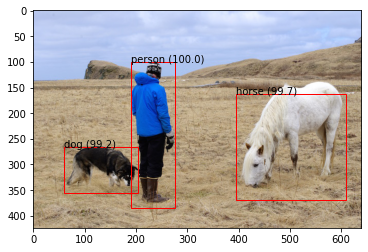

In [60]:
draw_results(photo_filename, v_boxes, v_labels, v_scores)

- This concludes the result of Object Detection using YOLOV3 model